<a href="https://colab.research.google.com/github/rob-rubio/DogGAN/blob/alpha/DogGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[]

In [ ]:
# from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from tensorflow.keras import backend

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from glob import glob
from PIL import Image

In [ ]:
from glob import glob
from PIL import Image

mypath = '../datasets/dog_images/n02086910-papillon/*' # edit with the path to your data
files = glob(mypath)

x = []
for file in files:
    image = Image.open(file)
    new_image = image.resize((128, 128))
    x.append(np.array(new_image))

x = np.array(x)

In [ ]:
x = np.load('../datasets/dog_images/db_nparray_128x128.npy')

In [ ]:
from glob import glob
from PIL import Image

mypath = '../datasets/dog_images/*/*' # edit with the path to your data

files = glob(mypath)
x = []
for file in files:
    image = Image.open(file)
    new_image = image.resize((128, 128))
    x.append(np.array(new_image))

x = np.array(x)

ValueError: could not broadcast input array from shape (128,128,3) into shape (128,128)

In [ ]:
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)

In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

#Define input image dimensions
#Large images take too much time and resources.
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)

##########################################################################
#Given input of noise (latent) vector, the Generator produces an image.
def build_generator():

    noise_shape = (100,) #1D array of size 100 (latent vector / noise)

#Define your generator network 
#Here we are only using Dense layers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.         

    model = Sequential()
    
    model.add(Dense(512, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1028))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    #Generated image

    return Model(noise, img)

#Alpha — α is a hyperparameter which controls the underlying value to which the
#function saturates negatives network inputs.
#Momentum — Speed up the training
##########################################################################

#Given an input image, the Discriminator outputs the likelihood of the image being real.
    #Binary classification - true or false (we're calling it validity)

def build_discriminator():
    
    
    model = Sequential()
    
    # model.add(Conv2D(3, 3, input_shape=img_shape))
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    # model.add(Dropout(0.2))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    # model.add(Dropout(0.2))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    
    img = Input(shape=img_shape)
    validity = model(img)
    
    return Model(img, validity)
#The validity is the Discriminator’s guess of input being real or not.

[[[  1   2   0]
  [  1   1   0]
  [  1   1   1]
  ...
  [140 136  89]
  [139 135  88]
  [137 133  86]]

 [[  2   3   0]
  [  1   2   0]
  [  1   1   2]
  ...
  [140 136  89]
  [139 135  88]
  [138 134  87]]

 [[  6   7   2]
  [  5   6   3]
  [  5   5   4]
  ...
  [141 137  90]
  [140 136  89]
  [138 134  87]]

 ...

 [[129 115  68]
  [126 112  65]
  [117 103  56]
  ...
  [ 89  74  37]
  [ 89  73  36]
  [ 87  71  34]]

 [[129 116  71]
  [116 103  58]
  [127 114  69]
  ...
  [ 92  76  43]
  [ 96  80  47]
  [ 92  76  43]]

 [[116 103  58]
  [126 113  68]
  [138 125  80]
  ...
  [ 86  70  37]
  [ 91  75  42]
  [ 92  76  43]]]


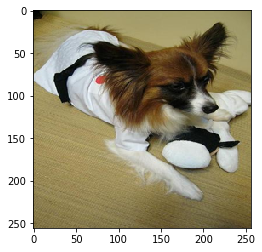

In [ ]:
plt.imshow(x[5])
print(x[5])

In [ ]:
#Now that we have constructed our two models it’s time to pit them against each other.
#We do this by defining a training function, loading the data set, re-scaling our training
#images and setting the ground truths. 
def train(epochs, batch_size=100, save_interval=50):

    # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (x.astype(np.float32) - 127.5) / 127.5

    #Add channels dimension. As the input to our gen and discr. has a shape 28x28x1.
    # X_train = np.expand_dims(X_train, axis=3) 

    half_batch = int(batch_size / 2)


#We then loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true dataset, generating a set of images from our
#Generator, feeding both set of images into our Discriminator, and finally setting the
#loss parameters for both the real and fake images, as well as the combined loss. 
    
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

 
        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately
        #Research showed that separate training is more effective. 
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    #take average loss from real and fake images. 
    #
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

#And within the same loop we train our Generator, by setting the input noise and
#ultimately training the Generator to have the Discriminator label its samples as valid
#by specifying the gradient loss.
        # ---------------------
        #  Train Generator
        # ---------------------
#Create noise vectors as input for generator. 
#Create as many noise vectors as defined by the batch size. 
#Based on normal distribution. Output will be of size (batch size, 100)
        noise = np.random.normal(0, 1, (batch_size, 100)) 

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the genrator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
        g_loss = combined.train_on_batch(noise, valid_y)


#Additionally, in order for us to keep track of our training process, we print the
#progress and save the sample image output depending on the epoch interval specified.  
# Plot the progress
        
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            # save_imgs(epoch)
            save_baseline(epoch)

#when the specific sample_interval is hit, we call the
#sample_image function. Which looks as follows.

def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    gen_imgs = gen_imgs*255

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            # axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].imshow(gen_imgs[cnt, :,:,0])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

def save_baseline(epoch):
    v = np.zeros(100)+0.5
    fimg = generator.predict(np.array(([v,v])))[0]
    fimg = (0.5+0.5*fimg)*255
    fimg = np.array(fimg, 'i')
    plt.imsave('./images/baseline_%d.png' % epoch, fimg.astype('uint8'))
    plt.close()
#This function saves our images for us to view


In [ ]:
#Let us also define our optimizer for easy use later on.
#That way if you change your mind, you can change it easily here
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.

# Build and compile the discriminator first. 
#Generator will be trained as part of the combined model, later. 
#pick the loss function and the type of metric to keep track.                 
#Binary cross entropy as we are doing prediction and it is a better
#loss function compared to MSE or other. 
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

#build and compile our Discriminator, pick the loss function

#SInce we are only generating (faking) images, let us not track any metrics.
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

##This builds the Generator and defines the input noise. 
#In a GAN the Generator network takes noise z as an input to produce its images.  
z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

#This ensures that when we combine our networks we only train the Generator.
#While generator training we do not want discriminator weights to be adjusted. 
#This Doesn't affect the above descriminator training.     
discriminator.trainable = False  

#This specifies that our Discriminator will take the images generated by our Generator
#and true dataset and set its output to a parameter called valid, which will indicate
#whether the input is real or not.  
valid = discriminator(img)  #Validity check on the generated image


#Here we combined the models and also set our loss function and optimizer. 
#Again, we are only training the generator here. 
#The ultimate goal here is for the Generator to fool the Discriminator.  
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_58 (Dense)             (None, 512)               25166336  
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 257       
Total params: 25,297,921
Trainable params: 25,297,921
Non-trainable params: 0
_________________________________________

In [ ]:
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
train(epochs=10000, batch_size=50, save_interval=25)

0 [D loss: 0.748170, acc.: 36.00%] [G loss: 0.688849]
1 [D loss: 0.867345, acc.: 78.00%] [G loss: 0.534671]
2 [D loss: 0.762700, acc.: 58.00%] [G loss: 0.391633]
3 [D loss: 0.692864, acc.: 50.00%] [G loss: 0.199009]
4 [D loss: 0.577893, acc.: 56.00%] [G loss: 0.186237]
5 [D loss: 0.639504, acc.: 56.00%] [G loss: 0.302482]
6 [D loss: 0.711569, acc.: 60.00%] [G loss: 0.339955]
7 [D loss: 0.653170, acc.: 68.00%] [G loss: 0.691794]
8 [D loss: 0.766513, acc.: 64.00%] [G loss: 0.580194]
9 [D loss: 0.488206, acc.: 70.00%] [G loss: 0.617057]
10 [D loss: 0.355594, acc.: 84.00%] [G loss: 0.901728]
11 [D loss: 0.746214, acc.: 68.00%] [G loss: 1.045574]
12 [D loss: 0.618115, acc.: 70.00%] [G loss: 1.674333]
13 [D loss: 0.835233, acc.: 56.00%] [G loss: 1.559935]
14 [D loss: 0.906761, acc.: 68.00%] [G loss: 2.104110]
15 [D loss: 0.446757, acc.: 84.00%] [G loss: 1.993484]
16 [D loss: 1.492093, acc.: 60.00%] [G loss: 2.462540]
17 [D loss: 0.524684, acc.: 84.00%] [G loss: 2.502118]
18 [D loss: 0.619010

135 [D loss: 1.019903, acc.: 62.00%] [G loss: 2.465448]
136 [D loss: 0.469922, acc.: 76.00%] [G loss: 4.285856]
137 [D loss: 0.342528, acc.: 92.00%] [G loss: 2.704589]
138 [D loss: 0.844762, acc.: 72.00%] [G loss: 2.786673]
139 [D loss: 0.899704, acc.: 70.00%] [G loss: 2.894164]
140 [D loss: 0.258213, acc.: 94.00%] [G loss: 3.242285]
141 [D loss: 0.406272, acc.: 80.00%] [G loss: 2.750342]
142 [D loss: 0.394758, acc.: 84.00%] [G loss: 3.588586]
143 [D loss: 0.855551, acc.: 76.00%] [G loss: 2.224701]
144 [D loss: 0.803669, acc.: 72.00%] [G loss: 2.313330]
145 [D loss: 1.730243, acc.: 44.00%] [G loss: 1.743093]
146 [D loss: 1.142465, acc.: 64.00%] [G loss: 3.696586]
147 [D loss: 0.199508, acc.: 94.00%] [G loss: 4.204353]
148 [D loss: 0.885875, acc.: 72.00%] [G loss: 2.790935]
149 [D loss: 0.415545, acc.: 80.00%] [G loss: 3.406608]
150 [D loss: 0.981086, acc.: 60.00%] [G loss: 2.225290]
151 [D loss: 0.735356, acc.: 74.00%] [G loss: 2.947622]
152 [D loss: 0.063244, acc.: 100.00%] [G loss: 4

282 [D loss: 0.551443, acc.: 72.00%] [G loss: 3.213531]
283 [D loss: 0.465865, acc.: 82.00%] [G loss: 4.214427]
284 [D loss: 0.466313, acc.: 78.00%] [G loss: 3.385603]
285 [D loss: 0.631187, acc.: 76.00%] [G loss: 3.871486]
286 [D loss: 0.237822, acc.: 92.00%] [G loss: 4.233961]
287 [D loss: 0.658852, acc.: 74.00%] [G loss: 4.539133]
288 [D loss: 0.799980, acc.: 68.00%] [G loss: 3.717571]
289 [D loss: 0.477756, acc.: 80.00%] [G loss: 3.521639]
290 [D loss: 0.245470, acc.: 90.00%] [G loss: 3.738635]
291 [D loss: 0.567105, acc.: 70.00%] [G loss: 2.564572]
292 [D loss: 0.616888, acc.: 84.00%] [G loss: 4.562222]
293 [D loss: 0.489057, acc.: 80.00%] [G loss: 4.048554]
294 [D loss: 0.211596, acc.: 88.00%] [G loss: 4.386727]
295 [D loss: 0.911802, acc.: 64.00%] [G loss: 2.299402]
296 [D loss: 0.268649, acc.: 90.00%] [G loss: 4.381398]
297 [D loss: 0.614382, acc.: 70.00%] [G loss: 3.807155]
298 [D loss: 0.307510, acc.: 90.00%] [G loss: 4.485719]
299 [D loss: 0.707608, acc.: 70.00%] [G loss: 4.

431 [D loss: 0.123354, acc.: 96.00%] [G loss: 4.213272]
432 [D loss: 0.383219, acc.: 82.00%] [G loss: 4.624068]
433 [D loss: 0.195692, acc.: 90.00%] [G loss: 4.672666]
434 [D loss: 0.307058, acc.: 90.00%] [G loss: 4.599508]
435 [D loss: 0.128110, acc.: 98.00%] [G loss: 4.697277]
436 [D loss: 0.538041, acc.: 78.00%] [G loss: 4.353747]
437 [D loss: 0.103558, acc.: 98.00%] [G loss: 5.255757]
438 [D loss: 0.481904, acc.: 78.00%] [G loss: 4.016418]
439 [D loss: 0.160008, acc.: 92.00%] [G loss: 4.938456]
440 [D loss: 0.192272, acc.: 94.00%] [G loss: 4.064685]
441 [D loss: 0.208920, acc.: 88.00%] [G loss: 5.013579]
442 [D loss: 0.527400, acc.: 72.00%] [G loss: 4.797307]
443 [D loss: 0.241872, acc.: 90.00%] [G loss: 4.362761]
444 [D loss: 0.133292, acc.: 92.00%] [G loss: 4.017292]
445 [D loss: 0.255744, acc.: 86.00%] [G loss: 4.367891]
446 [D loss: 0.087312, acc.: 98.00%] [G loss: 4.755857]
447 [D loss: 1.287247, acc.: 60.00%] [G loss: 7.462528]
448 [D loss: 1.475296, acc.: 60.00%] [G loss: 6.

578 [D loss: 0.384159, acc.: 82.00%] [G loss: 3.517016]
579 [D loss: 0.151541, acc.: 94.00%] [G loss: 4.769059]
580 [D loss: 0.104119, acc.: 98.00%] [G loss: 4.965721]
581 [D loss: 0.067868, acc.: 100.00%] [G loss: 5.497194]
582 [D loss: 0.271183, acc.: 94.00%] [G loss: 3.503619]
583 [D loss: 0.278907, acc.: 84.00%] [G loss: 4.759494]
584 [D loss: 0.173453, acc.: 96.00%] [G loss: 5.713762]
585 [D loss: 0.558226, acc.: 72.00%] [G loss: 3.783538]
586 [D loss: 0.281391, acc.: 86.00%] [G loss: 6.535912]
587 [D loss: 0.156479, acc.: 92.00%] [G loss: 5.624691]
588 [D loss: 0.464901, acc.: 84.00%] [G loss: 5.261796]
589 [D loss: 0.068548, acc.: 96.00%] [G loss: 5.529979]
590 [D loss: 0.458747, acc.: 82.00%] [G loss: 5.374601]
591 [D loss: 0.019502, acc.: 100.00%] [G loss: 6.024646]
592 [D loss: 0.589393, acc.: 74.00%] [G loss: 5.802022]
593 [D loss: 0.055202, acc.: 100.00%] [G loss: 6.090181]
594 [D loss: 0.258657, acc.: 92.00%] [G loss: 4.962625]
595 [D loss: 0.365560, acc.: 80.00%] [G loss:

723 [D loss: 0.046754, acc.: 100.00%] [G loss: 6.019674]
724 [D loss: 0.116220, acc.: 96.00%] [G loss: 3.733951]
725 [D loss: 0.107378, acc.: 96.00%] [G loss: 5.482655]
726 [D loss: 0.113852, acc.: 98.00%] [G loss: 5.101101]
727 [D loss: 0.081751, acc.: 98.00%] [G loss: 5.518750]
728 [D loss: 0.125561, acc.: 90.00%] [G loss: 6.068215]
729 [D loss: 0.146703, acc.: 94.00%] [G loss: 4.101237]
730 [D loss: 0.040797, acc.: 100.00%] [G loss: 4.949037]
731 [D loss: 0.065634, acc.: 98.00%] [G loss: 6.356713]
732 [D loss: 0.081748, acc.: 100.00%] [G loss: 4.773576]
733 [D loss: 0.021666, acc.: 100.00%] [G loss: 5.581084]
734 [D loss: 0.139825, acc.: 94.00%] [G loss: 6.250480]
735 [D loss: 0.081064, acc.: 96.00%] [G loss: 5.229174]
736 [D loss: 0.041251, acc.: 100.00%] [G loss: 6.009260]
737 [D loss: 0.071301, acc.: 98.00%] [G loss: 5.843768]
738 [D loss: 0.031944, acc.: 100.00%] [G loss: 6.231935]
739 [D loss: 0.032072, acc.: 100.00%] [G loss: 6.043887]
740 [D loss: 0.133180, acc.: 96.00%] [G l

868 [D loss: 0.037562, acc.: 98.00%] [G loss: 5.006684]
869 [D loss: 0.068045, acc.: 98.00%] [G loss: 4.174494]
870 [D loss: 0.070353, acc.: 98.00%] [G loss: 4.325809]
871 [D loss: 0.064590, acc.: 98.00%] [G loss: 5.159235]
872 [D loss: 0.060388, acc.: 100.00%] [G loss: 5.324173]
873 [D loss: 0.028383, acc.: 100.00%] [G loss: 5.088972]
874 [D loss: 0.097667, acc.: 96.00%] [G loss: 4.072636]
875 [D loss: 0.083307, acc.: 98.00%] [G loss: 5.674064]
876 [D loss: 0.024297, acc.: 100.00%] [G loss: 6.488142]
877 [D loss: 0.056972, acc.: 100.00%] [G loss: 4.666242]
878 [D loss: 0.051155, acc.: 98.00%] [G loss: 4.723297]
879 [D loss: 0.050056, acc.: 100.00%] [G loss: 3.966282]
880 [D loss: 0.046174, acc.: 100.00%] [G loss: 4.756243]
881 [D loss: 0.043724, acc.: 100.00%] [G loss: 6.011049]
882 [D loss: 0.158171, acc.: 94.00%] [G loss: 5.934361]
883 [D loss: 0.032798, acc.: 100.00%] [G loss: 6.089086]
884 [D loss: 0.154719, acc.: 94.00%] [G loss: 5.415112]
885 [D loss: 0.064009, acc.: 100.00%] [G

1013 [D loss: 0.006275, acc.: 100.00%] [G loss: 6.253856]
1014 [D loss: 0.152909, acc.: 96.00%] [G loss: 3.981786]
1015 [D loss: 0.036876, acc.: 100.00%] [G loss: 5.182451]
1016 [D loss: 0.141150, acc.: 92.00%] [G loss: 5.365575]
1017 [D loss: 0.046203, acc.: 100.00%] [G loss: 6.085002]
1018 [D loss: 0.142698, acc.: 96.00%] [G loss: 5.449929]
1019 [D loss: 0.026902, acc.: 100.00%] [G loss: 5.836330]
1020 [D loss: 0.054625, acc.: 98.00%] [G loss: 4.648610]
1021 [D loss: 0.010894, acc.: 100.00%] [G loss: 5.013562]
1022 [D loss: 0.024960, acc.: 100.00%] [G loss: 4.954149]
1023 [D loss: 0.122335, acc.: 96.00%] [G loss: 4.234841]
1024 [D loss: 0.366994, acc.: 88.00%] [G loss: 6.425120]
1025 [D loss: 0.188127, acc.: 94.00%] [G loss: 5.008413]
1026 [D loss: 0.095738, acc.: 98.00%] [G loss: 3.794745]
1027 [D loss: 0.044694, acc.: 100.00%] [G loss: 4.363486]
1028 [D loss: 0.296453, acc.: 90.00%] [G loss: 4.444876]
1029 [D loss: 0.014737, acc.: 100.00%] [G loss: 6.749490]
1030 [D loss: 0.633269,

1157 [D loss: 0.026659, acc.: 100.00%] [G loss: 6.704581]
1158 [D loss: 0.022454, acc.: 100.00%] [G loss: 5.834943]
1159 [D loss: 0.023734, acc.: 100.00%] [G loss: 6.353633]
1160 [D loss: 0.010624, acc.: 100.00%] [G loss: 5.988043]
1161 [D loss: 0.031946, acc.: 100.00%] [G loss: 5.436012]
1162 [D loss: 0.015090, acc.: 100.00%] [G loss: 7.883458]
1163 [D loss: 0.041597, acc.: 98.00%] [G loss: 5.038874]
1164 [D loss: 0.050728, acc.: 98.00%] [G loss: 7.872703]
1165 [D loss: 0.018485, acc.: 100.00%] [G loss: 7.351754]
1166 [D loss: 0.011291, acc.: 100.00%] [G loss: 8.226435]
1167 [D loss: 0.106080, acc.: 96.00%] [G loss: 5.300164]
1168 [D loss: 0.064738, acc.: 96.00%] [G loss: 5.255927]
1169 [D loss: 0.015714, acc.: 100.00%] [G loss: 7.262378]
1170 [D loss: 0.137526, acc.: 94.00%] [G loss: 7.726818]
1171 [D loss: 0.072085, acc.: 96.00%] [G loss: 6.029309]
1172 [D loss: 0.053234, acc.: 98.00%] [G loss: 6.951291]
1173 [D loss: 0.021860, acc.: 100.00%] [G loss: 7.771987]
1174 [D loss: 0.25169

1301 [D loss: 0.287323, acc.: 96.00%] [G loss: 6.376107]
1302 [D loss: 0.079754, acc.: 96.00%] [G loss: 5.843946]
1303 [D loss: 0.126657, acc.: 96.00%] [G loss: 8.353166]
1304 [D loss: 0.047258, acc.: 98.00%] [G loss: 7.071574]
1305 [D loss: 0.219635, acc.: 94.00%] [G loss: 6.678463]
1306 [D loss: 0.031179, acc.: 100.00%] [G loss: 7.302259]
1307 [D loss: 0.472578, acc.: 92.00%] [G loss: 5.639204]
1308 [D loss: 0.048190, acc.: 98.00%] [G loss: 6.768999]
1309 [D loss: 0.122554, acc.: 98.00%] [G loss: 4.635437]
1310 [D loss: 0.045529, acc.: 100.00%] [G loss: 5.598302]
1311 [D loss: 0.020005, acc.: 100.00%] [G loss: 6.395928]
1312 [D loss: 0.189595, acc.: 88.00%] [G loss: 4.979007]
1313 [D loss: 0.066219, acc.: 96.00%] [G loss: 6.527489]
1314 [D loss: 0.008178, acc.: 100.00%] [G loss: 6.914696]
1315 [D loss: 0.010104, acc.: 100.00%] [G loss: 6.265785]
1316 [D loss: 0.008860, acc.: 100.00%] [G loss: 5.785627]
1317 [D loss: 0.091176, acc.: 98.00%] [G loss: 5.681534]
1318 [D loss: 0.006827, a

1445 [D loss: 0.115645, acc.: 96.00%] [G loss: 6.538237]
1446 [D loss: 0.057347, acc.: 98.00%] [G loss: 7.364476]
1447 [D loss: 0.310952, acc.: 88.00%] [G loss: 5.681533]
1448 [D loss: 0.066461, acc.: 98.00%] [G loss: 8.183793]
1449 [D loss: 0.003748, acc.: 100.00%] [G loss: 8.116661]
1450 [D loss: 0.172452, acc.: 98.00%] [G loss: 5.217617]
1451 [D loss: 0.052821, acc.: 100.00%] [G loss: 5.180280]
1452 [D loss: 0.050185, acc.: 98.00%] [G loss: 5.406218]
1453 [D loss: 0.037848, acc.: 100.00%] [G loss: 6.463840]
1454 [D loss: 0.074851, acc.: 96.00%] [G loss: 5.231086]
1455 [D loss: 0.007067, acc.: 100.00%] [G loss: 5.520795]
1456 [D loss: 0.006791, acc.: 100.00%] [G loss: 5.521720]
1457 [D loss: 0.137687, acc.: 96.00%] [G loss: 6.021316]
1458 [D loss: 0.009765, acc.: 100.00%] [G loss: 7.482018]
1459 [D loss: 0.063613, acc.: 98.00%] [G loss: 4.646070]
1460 [D loss: 0.080982, acc.: 98.00%] [G loss: 3.743362]
1461 [D loss: 0.013341, acc.: 100.00%] [G loss: 5.383026]
1462 [D loss: 0.009758, 

1587 [D loss: 0.017806, acc.: 100.00%] [G loss: 6.285969]
1588 [D loss: 0.149752, acc.: 90.00%] [G loss: 7.487043]
1589 [D loss: 0.020438, acc.: 98.00%] [G loss: 9.083833]
1590 [D loss: 0.004557, acc.: 100.00%] [G loss: 9.034162]
1591 [D loss: 0.003145, acc.: 100.00%] [G loss: 8.214136]
1592 [D loss: 0.004282, acc.: 100.00%] [G loss: 7.846035]
1593 [D loss: 0.123433, acc.: 96.00%] [G loss: 8.453903]
1594 [D loss: 0.045957, acc.: 98.00%] [G loss: 7.976794]
1595 [D loss: 0.360892, acc.: 94.00%] [G loss: 5.946694]
1596 [D loss: 0.070717, acc.: 96.00%] [G loss: 8.991027]
1597 [D loss: 0.086306, acc.: 96.00%] [G loss: 8.033651]
1598 [D loss: 0.019122, acc.: 100.00%] [G loss: 8.748569]
1599 [D loss: 0.079117, acc.: 98.00%] [G loss: 6.178271]
1600 [D loss: 0.010558, acc.: 100.00%] [G loss: 6.213033]
1601 [D loss: 0.038775, acc.: 96.00%] [G loss: 6.323143]
1602 [D loss: 0.040095, acc.: 98.00%] [G loss: 5.710758]
1603 [D loss: 0.018974, acc.: 100.00%] [G loss: 6.586103]
1604 [D loss: 0.151117, 

1729 [D loss: 0.028014, acc.: 100.00%] [G loss: 8.682181]
1730 [D loss: 0.368558, acc.: 88.00%] [G loss: 7.058273]
1731 [D loss: 0.003725, acc.: 100.00%] [G loss: 8.597797]
1732 [D loss: 0.002716, acc.: 100.00%] [G loss: 8.559235]
1733 [D loss: 0.106338, acc.: 96.00%] [G loss: 7.850204]
1734 [D loss: 0.009587, acc.: 100.00%] [G loss: 8.297502]
1735 [D loss: 0.041873, acc.: 96.00%] [G loss: 7.022453]
1736 [D loss: 0.024794, acc.: 100.00%] [G loss: 6.970656]
1737 [D loss: 0.039089, acc.: 98.00%] [G loss: 7.720843]
1738 [D loss: 0.786462, acc.: 82.00%] [G loss: 17.455986]
1739 [D loss: 1.945466, acc.: 68.00%] [G loss: 7.906079]
1740 [D loss: 0.005095, acc.: 100.00%] [G loss: 12.412156]
1741 [D loss: 1.683851, acc.: 90.00%] [G loss: 9.787520]
1742 [D loss: 0.207049, acc.: 94.00%] [G loss: 6.879070]
1743 [D loss: 0.020511, acc.: 100.00%] [G loss: 7.442007]
1744 [D loss: 1.401034, acc.: 70.00%] [G loss: 14.222241]
1745 [D loss: 0.589089, acc.: 94.00%] [G loss: 12.131257]
1746 [D loss: 0.3322

1873 [D loss: 0.155563, acc.: 94.00%] [G loss: 9.571634]
1874 [D loss: 0.476788, acc.: 88.00%] [G loss: 6.320300]
1875 [D loss: 0.047403, acc.: 100.00%] [G loss: 6.510907]
1876 [D loss: 0.305381, acc.: 90.00%] [G loss: 6.623955]
1877 [D loss: 0.274247, acc.: 92.00%] [G loss: 8.459606]
1878 [D loss: 0.140502, acc.: 94.00%] [G loss: 6.561355]
1879 [D loss: 0.315840, acc.: 94.00%] [G loss: 8.451130]
1880 [D loss: 0.175027, acc.: 94.00%] [G loss: 6.439909]
1881 [D loss: 0.193735, acc.: 90.00%] [G loss: 6.087638]
1882 [D loss: 0.148990, acc.: 94.00%] [G loss: 10.360469]
1883 [D loss: 0.514236, acc.: 86.00%] [G loss: 4.727864]
1884 [D loss: 0.355057, acc.: 88.00%] [G loss: 11.721365]
1885 [D loss: 0.750854, acc.: 82.00%] [G loss: 7.091555]
1886 [D loss: 0.090260, acc.: 96.00%] [G loss: 9.016262]
1887 [D loss: 0.213551, acc.: 96.00%] [G loss: 10.419703]
1888 [D loss: 0.147643, acc.: 96.00%] [G loss: 6.669890]
1889 [D loss: 0.477168, acc.: 84.00%] [G loss: 9.504546]
1890 [D loss: 0.349696, acc

2018 [D loss: 0.243360, acc.: 92.00%] [G loss: 8.744846]
2019 [D loss: 0.050941, acc.: 98.00%] [G loss: 10.105615]
2020 [D loss: 1.760853, acc.: 68.00%] [G loss: 4.785164]
2021 [D loss: 0.239150, acc.: 90.00%] [G loss: 8.616647]
2022 [D loss: 0.173333, acc.: 96.00%] [G loss: 7.723541]
2023 [D loss: 0.139635, acc.: 94.00%] [G loss: 5.341666]
2024 [D loss: 0.277420, acc.: 94.00%] [G loss: 4.553228]
2025 [D loss: 0.346310, acc.: 86.00%] [G loss: 7.908946]
2026 [D loss: 0.076356, acc.: 94.00%] [G loss: 7.468187]
2027 [D loss: 0.158200, acc.: 90.00%] [G loss: 7.225557]
2028 [D loss: 0.145662, acc.: 96.00%] [G loss: 8.106695]
2029 [D loss: 0.180446, acc.: 94.00%] [G loss: 6.147650]
2030 [D loss: 0.133699, acc.: 96.00%] [G loss: 7.825677]
2031 [D loss: 0.048715, acc.: 98.00%] [G loss: 7.464708]
2032 [D loss: 0.038134, acc.: 100.00%] [G loss: 6.614368]
2033 [D loss: 0.179222, acc.: 94.00%] [G loss: 5.565243]
2034 [D loss: 0.228673, acc.: 90.00%] [G loss: 5.934333]
2035 [D loss: 0.721559, acc.:

2162 [D loss: 0.764557, acc.: 86.00%] [G loss: 4.983922]
2163 [D loss: 0.469976, acc.: 86.00%] [G loss: 8.163610]
2164 [D loss: 0.181897, acc.: 94.00%] [G loss: 9.671436]
2165 [D loss: 0.011354, acc.: 100.00%] [G loss: 10.294278]
2166 [D loss: 0.048559, acc.: 98.00%] [G loss: 7.699233]
2167 [D loss: 0.025847, acc.: 98.00%] [G loss: 7.978123]
2168 [D loss: 0.130435, acc.: 96.00%] [G loss: 8.115986]
2169 [D loss: 0.079561, acc.: 96.00%] [G loss: 7.766365]
2170 [D loss: 0.032785, acc.: 100.00%] [G loss: 8.203534]
2171 [D loss: 0.149294, acc.: 94.00%] [G loss: 5.502766]
2172 [D loss: 0.053422, acc.: 98.00%] [G loss: 6.589216]
2173 [D loss: 0.044706, acc.: 96.00%] [G loss: 7.241494]
2174 [D loss: 0.134048, acc.: 96.00%] [G loss: 4.753433]
2175 [D loss: 0.017624, acc.: 100.00%] [G loss: 5.177481]
2176 [D loss: 0.028130, acc.: 100.00%] [G loss: 5.959220]
2177 [D loss: 0.046112, acc.: 100.00%] [G loss: 7.818773]
2178 [D loss: 0.014436, acc.: 100.00%] [G loss: 8.488467]
2179 [D loss: 0.070829, 

2304 [D loss: 0.069145, acc.: 96.00%] [G loss: 8.491075]
2305 [D loss: 0.030194, acc.: 100.00%] [G loss: 8.597889]
2306 [D loss: 0.003613, acc.: 100.00%] [G loss: 9.397625]
2307 [D loss: 0.071808, acc.: 98.00%] [G loss: 8.397161]
2308 [D loss: 0.029164, acc.: 100.00%] [G loss: 8.901974]
2309 [D loss: 0.049766, acc.: 98.00%] [G loss: 8.705524]
2310 [D loss: 0.036142, acc.: 98.00%] [G loss: 7.718309]
2311 [D loss: 0.042204, acc.: 98.00%] [G loss: 7.961875]
2312 [D loss: 0.023029, acc.: 98.00%] [G loss: 10.106283]
2313 [D loss: 0.002173, acc.: 100.00%] [G loss: 10.039926]
2314 [D loss: 0.030075, acc.: 98.00%] [G loss: 7.530207]
2315 [D loss: 0.019973, acc.: 100.00%] [G loss: 6.617990]
2316 [D loss: 0.010650, acc.: 100.00%] [G loss: 6.163033]
2317 [D loss: 0.013412, acc.: 100.00%] [G loss: 6.898637]
2318 [D loss: 0.103967, acc.: 96.00%] [G loss: 6.961681]
2319 [D loss: 0.006885, acc.: 100.00%] [G loss: 8.200479]
2320 [D loss: 0.047403, acc.: 98.00%] [G loss: 5.764925]
2321 [D loss: 0.08514

2445 [D loss: 0.257910, acc.: 90.00%] [G loss: 12.261456]
2446 [D loss: 0.013748, acc.: 100.00%] [G loss: 14.270586]
2447 [D loss: 0.569114, acc.: 90.00%] [G loss: 5.480014]
2448 [D loss: 0.120677, acc.: 94.00%] [G loss: 7.162646]
2449 [D loss: 0.032764, acc.: 98.00%] [G loss: 8.633361]
2450 [D loss: 0.131585, acc.: 96.00%] [G loss: 7.868851]
2451 [D loss: 0.022361, acc.: 100.00%] [G loss: 8.135010]
2452 [D loss: 0.021377, acc.: 100.00%] [G loss: 8.658298]
2453 [D loss: 0.007867, acc.: 100.00%] [G loss: 8.004928]
2454 [D loss: 0.004656, acc.: 100.00%] [G loss: 8.005652]
2455 [D loss: 0.011598, acc.: 100.00%] [G loss: 8.308906]
2456 [D loss: 0.030604, acc.: 98.00%] [G loss: 7.215016]
2457 [D loss: 0.007098, acc.: 100.00%] [G loss: 6.714013]
2458 [D loss: 0.023122, acc.: 100.00%] [G loss: 7.952480]
2459 [D loss: 0.047654, acc.: 98.00%] [G loss: 7.214733]
2460 [D loss: 0.005690, acc.: 100.00%] [G loss: 6.972879]
2461 [D loss: 0.012179, acc.: 100.00%] [G loss: 6.831262]
2462 [D loss: 0.004

2587 [D loss: 0.055033, acc.: 98.00%] [G loss: 7.550393]
2588 [D loss: 0.015222, acc.: 100.00%] [G loss: 9.000180]
2589 [D loss: 0.001672, acc.: 100.00%] [G loss: 9.741133]
2590 [D loss: 0.043464, acc.: 96.00%] [G loss: 5.395479]
2591 [D loss: 0.032689, acc.: 100.00%] [G loss: 6.799770]
2592 [D loss: 0.041558, acc.: 98.00%] [G loss: 6.974550]
2593 [D loss: 0.011227, acc.: 100.00%] [G loss: 8.017932]
2594 [D loss: 0.001590, acc.: 100.00%] [G loss: 8.533858]
2595 [D loss: 0.061820, acc.: 98.00%] [G loss: 8.266681]
2596 [D loss: 0.065743, acc.: 98.00%] [G loss: 6.624369]
2597 [D loss: 0.012111, acc.: 100.00%] [G loss: 6.969109]
2598 [D loss: 0.058096, acc.: 98.00%] [G loss: 7.108244]
2599 [D loss: 0.003162, acc.: 100.00%] [G loss: 8.658918]
2600 [D loss: 0.019978, acc.: 100.00%] [G loss: 8.452985]
2601 [D loss: 0.009585, acc.: 100.00%] [G loss: 8.317929]
2602 [D loss: 0.020763, acc.: 100.00%] [G loss: 6.901817]
2603 [D loss: 0.147752, acc.: 90.00%] [G loss: 4.627483]
2604 [D loss: 0.09059

2731 [D loss: 0.016210, acc.: 100.00%] [G loss: 9.387798]
2732 [D loss: 0.078069, acc.: 98.00%] [G loss: 7.449047]
2733 [D loss: 0.016759, acc.: 100.00%] [G loss: 7.161411]
2734 [D loss: 0.176198, acc.: 94.00%] [G loss: 10.633139]
2735 [D loss: 0.376242, acc.: 88.00%] [G loss: 14.137827]
2736 [D loss: 0.299524, acc.: 96.00%] [G loss: 10.781670]
2737 [D loss: 0.322352, acc.: 96.00%] [G loss: 6.217015]
2738 [D loss: 0.136219, acc.: 98.00%] [G loss: 5.607154]
2739 [D loss: 0.044396, acc.: 98.00%] [G loss: 6.980203]
2740 [D loss: 0.163522, acc.: 92.00%] [G loss: 9.218555]
2741 [D loss: 0.097669, acc.: 98.00%] [G loss: 9.131702]
2742 [D loss: 0.123684, acc.: 96.00%] [G loss: 9.862489]
2743 [D loss: 0.003462, acc.: 100.00%] [G loss: 10.108377]
2744 [D loss: 0.022007, acc.: 100.00%] [G loss: 8.811502]
2745 [D loss: 0.005917, acc.: 100.00%] [G loss: 8.192388]
2746 [D loss: 0.049045, acc.: 98.00%] [G loss: 9.186207]
2747 [D loss: 0.015475, acc.: 100.00%] [G loss: 9.939631]
2748 [D loss: 0.06995

2873 [D loss: 0.114157, acc.: 94.00%] [G loss: 11.057842]
2874 [D loss: 0.553596, acc.: 96.00%] [G loss: 8.098673]
2875 [D loss: 0.075067, acc.: 96.00%] [G loss: 7.180300]
2876 [D loss: 0.112971, acc.: 96.00%] [G loss: 8.482099]
2877 [D loss: 0.028800, acc.: 98.00%] [G loss: 10.289839]
2878 [D loss: 0.002360, acc.: 100.00%] [G loss: 10.810083]
2879 [D loss: 0.085456, acc.: 96.00%] [G loss: 9.501896]
2880 [D loss: 0.016322, acc.: 100.00%] [G loss: 9.492352]
2881 [D loss: 0.142437, acc.: 94.00%] [G loss: 7.442792]
2882 [D loss: 0.004861, acc.: 100.00%] [G loss: 6.712451]
2883 [D loss: 0.048666, acc.: 98.00%] [G loss: 7.673007]
2884 [D loss: 0.183798, acc.: 92.00%] [G loss: 7.572671]
2885 [D loss: 0.002109, acc.: 100.00%] [G loss: 8.564136]
2886 [D loss: 0.061731, acc.: 98.00%] [G loss: 5.812866]
2887 [D loss: 0.008559, acc.: 100.00%] [G loss: 5.034983]
2888 [D loss: 0.054237, acc.: 98.00%] [G loss: 6.983935]
2889 [D loss: 0.080434, acc.: 98.00%] [G loss: 6.618386]
2890 [D loss: 0.050211,

3018 [D loss: 0.060302, acc.: 98.00%] [G loss: 9.182714]
3019 [D loss: 0.064845, acc.: 96.00%] [G loss: 9.992773]
3020 [D loss: 0.038418, acc.: 98.00%] [G loss: 8.749674]
3021 [D loss: 0.039169, acc.: 100.00%] [G loss: 8.299973]
3022 [D loss: 0.010224, acc.: 100.00%] [G loss: 9.487253]
3023 [D loss: 0.053662, acc.: 98.00%] [G loss: 8.714447]
3024 [D loss: 0.300142, acc.: 96.00%] [G loss: 8.349483]
3025 [D loss: 0.137851, acc.: 96.00%] [G loss: 10.990806]
3026 [D loss: 0.001095, acc.: 100.00%] [G loss: 12.341922]
3027 [D loss: 0.245014, acc.: 96.00%] [G loss: 9.709677]
3028 [D loss: 0.014103, acc.: 100.00%] [G loss: 8.786653]
3029 [D loss: 0.281116, acc.: 94.00%] [G loss: 9.998339]
3030 [D loss: 0.004881, acc.: 100.00%] [G loss: 13.482314]
3031 [D loss: 0.440049, acc.: 92.00%] [G loss: 7.206231]
3032 [D loss: 0.071470, acc.: 94.00%] [G loss: 9.024984]
3033 [D loss: 0.007581, acc.: 100.00%] [G loss: 9.462983]
3034 [D loss: 0.052473, acc.: 98.00%] [G loss: 7.316388]
3035 [D loss: 0.010577

3162 [D loss: 0.028662, acc.: 98.00%] [G loss: 9.233715]
3163 [D loss: 0.181813, acc.: 90.00%] [G loss: 7.473540]
3164 [D loss: 0.157147, acc.: 96.00%] [G loss: 7.458681]
3165 [D loss: 0.048652, acc.: 98.00%] [G loss: 7.899528]
3166 [D loss: 0.055739, acc.: 98.00%] [G loss: 7.111437]
3167 [D loss: 0.012579, acc.: 100.00%] [G loss: 6.157233]
3168 [D loss: 0.140435, acc.: 96.00%] [G loss: 9.320560]
3169 [D loss: 0.013847, acc.: 100.00%] [G loss: 10.155968]
3170 [D loss: 0.014342, acc.: 100.00%] [G loss: 10.964819]
3171 [D loss: 0.130756, acc.: 98.00%] [G loss: 6.156191]
3172 [D loss: 0.083951, acc.: 94.00%] [G loss: 8.442652]
3173 [D loss: 0.055733, acc.: 96.00%] [G loss: 9.419319]
3174 [D loss: 0.096172, acc.: 94.00%] [G loss: 10.883610]
3175 [D loss: 0.165250, acc.: 94.00%] [G loss: 8.096655]
3176 [D loss: 0.019321, acc.: 100.00%] [G loss: 7.744636]
3177 [D loss: 0.017700, acc.: 100.00%] [G loss: 6.900801]
3178 [D loss: 0.041310, acc.: 98.00%] [G loss: 7.845792]
3179 [D loss: 0.002213,

3304 [D loss: 0.167345, acc.: 96.00%] [G loss: 8.909961]
3305 [D loss: 0.099923, acc.: 96.00%] [G loss: 9.721325]
3306 [D loss: 0.077339, acc.: 96.00%] [G loss: 7.654671]
3307 [D loss: 0.062272, acc.: 98.00%] [G loss: 8.669353]
3308 [D loss: 0.040171, acc.: 98.00%] [G loss: 11.055595]
3309 [D loss: 0.005773, acc.: 100.00%] [G loss: 8.815312]
3310 [D loss: 0.152248, acc.: 92.00%] [G loss: 10.597034]
3311 [D loss: 0.011319, acc.: 100.00%] [G loss: 11.576395]
3312 [D loss: 0.013775, acc.: 100.00%] [G loss: 9.012461]
3313 [D loss: 0.197152, acc.: 94.00%] [G loss: 10.612881]
3314 [D loss: 0.042405, acc.: 98.00%] [G loss: 11.377739]
3315 [D loss: 0.414511, acc.: 94.00%] [G loss: 9.130448]
3316 [D loss: 0.440602, acc.: 88.00%] [G loss: 12.462061]
3317 [D loss: 0.092330, acc.: 98.00%] [G loss: 14.412182]
3318 [D loss: 0.135126, acc.: 98.00%] [G loss: 9.688103]
3319 [D loss: 0.010648, acc.: 100.00%] [G loss: 9.582458]
3320 [D loss: 0.005119, acc.: 100.00%] [G loss: 8.476837]
3321 [D loss: 0.035

3446 [D loss: 0.001625, acc.: 100.00%] [G loss: 8.771490]
3447 [D loss: 0.009716, acc.: 100.00%] [G loss: 9.171496]
3448 [D loss: 0.022538, acc.: 100.00%] [G loss: 9.009127]
3449 [D loss: 0.028018, acc.: 100.00%] [G loss: 10.488562]
3450 [D loss: 0.035626, acc.: 100.00%] [G loss: 7.114762]
3451 [D loss: 0.012377, acc.: 100.00%] [G loss: 8.680544]
3452 [D loss: 0.009348, acc.: 100.00%] [G loss: 7.572295]
3453 [D loss: 0.014991, acc.: 100.00%] [G loss: 9.256746]
3454 [D loss: 0.083358, acc.: 98.00%] [G loss: 7.628148]
3455 [D loss: 0.019963, acc.: 100.00%] [G loss: 7.516531]
3456 [D loss: 0.011180, acc.: 100.00%] [G loss: 8.944201]
3457 [D loss: 0.064895, acc.: 96.00%] [G loss: 13.549993]
3458 [D loss: 0.085989, acc.: 98.00%] [G loss: 10.234358]
3459 [D loss: 0.036379, acc.: 100.00%] [G loss: 9.611183]
3460 [D loss: 0.178694, acc.: 94.00%] [G loss: 8.465969]
3461 [D loss: 0.044322, acc.: 98.00%] [G loss: 9.795873]
3462 [D loss: 0.004697, acc.: 100.00%] [G loss: 10.242868]
3463 [D loss: 0

3588 [D loss: 0.210998, acc.: 92.00%] [G loss: 5.324335]
3589 [D loss: 0.255174, acc.: 94.00%] [G loss: 11.169042]
3590 [D loss: 0.002336, acc.: 100.00%] [G loss: 14.787373]
3591 [D loss: 0.260488, acc.: 90.00%] [G loss: 11.807656]
3592 [D loss: 0.196659, acc.: 92.00%] [G loss: 13.130795]
3593 [D loss: 0.072060, acc.: 98.00%] [G loss: 14.465730]
3594 [D loss: 0.173656, acc.: 92.00%] [G loss: 8.765685]
3595 [D loss: 0.021148, acc.: 98.00%] [G loss: 7.477473]
3596 [D loss: 0.097597, acc.: 98.00%] [G loss: 8.421049]
3597 [D loss: 0.136239, acc.: 96.00%] [G loss: 8.116565]
3598 [D loss: 0.042126, acc.: 100.00%] [G loss: 8.218909]
3599 [D loss: 0.125923, acc.: 94.00%] [G loss: 9.188067]
3600 [D loss: 0.008769, acc.: 100.00%] [G loss: 9.429974]
3601 [D loss: 0.005722, acc.: 100.00%] [G loss: 10.068766]
3602 [D loss: 0.035100, acc.: 98.00%] [G loss: 8.002262]
3603 [D loss: 0.002307, acc.: 100.00%] [G loss: 8.941392]
3604 [D loss: 0.043858, acc.: 96.00%] [G loss: 9.822005]
3605 [D loss: 0.0766

3732 [D loss: 0.003774, acc.: 100.00%] [G loss: 8.129481]
3733 [D loss: 0.467666, acc.: 94.00%] [G loss: 6.738177]
3734 [D loss: 0.005924, acc.: 100.00%] [G loss: 9.007776]
3735 [D loss: 0.003787, acc.: 100.00%] [G loss: 9.675340]
3736 [D loss: 0.119422, acc.: 98.00%] [G loss: 7.865409]
3737 [D loss: 0.155125, acc.: 92.00%] [G loss: 7.098547]
3738 [D loss: 0.003204, acc.: 100.00%] [G loss: 8.352534]
3739 [D loss: 0.224102, acc.: 92.00%] [G loss: 9.275102]
3740 [D loss: 0.020190, acc.: 100.00%] [G loss: 8.332919]
3741 [D loss: 0.160810, acc.: 96.00%] [G loss: 10.097810]
3742 [D loss: 0.072428, acc.: 96.00%] [G loss: 10.408813]
3743 [D loss: 0.217465, acc.: 94.00%] [G loss: 9.905818]
3744 [D loss: 0.023720, acc.: 100.00%] [G loss: 10.887852]
3745 [D loss: 0.033935, acc.: 98.00%] [G loss: 10.619930]
3746 [D loss: 0.240055, acc.: 94.00%] [G loss: 7.356655]
3747 [D loss: 0.129469, acc.: 96.00%] [G loss: 7.730075]
3748 [D loss: 0.078130, acc.: 96.00%] [G loss: 9.783757]
3749 [D loss: 0.01987

3874 [D loss: 0.003780, acc.: 100.00%] [G loss: 10.456119]
3875 [D loss: 0.402787, acc.: 94.00%] [G loss: 7.619947]
3876 [D loss: 0.060169, acc.: 96.00%] [G loss: 9.402809]
3877 [D loss: 0.042571, acc.: 98.00%] [G loss: 11.004678]
3878 [D loss: 0.005990, acc.: 100.00%] [G loss: 10.259439]
3879 [D loss: 0.138400, acc.: 90.00%] [G loss: 6.293707]
3880 [D loss: 0.025797, acc.: 100.00%] [G loss: 6.722322]
3881 [D loss: 0.007744, acc.: 100.00%] [G loss: 7.414005]
3882 [D loss: 0.090936, acc.: 96.00%] [G loss: 6.551663]
3883 [D loss: 0.384837, acc.: 94.00%] [G loss: 9.867134]
3884 [D loss: 0.012645, acc.: 100.00%] [G loss: 13.414729]
3885 [D loss: 0.083434, acc.: 94.00%] [G loss: 8.135036]
3886 [D loss: 0.084384, acc.: 96.00%] [G loss: 8.794452]
3887 [D loss: 0.002484, acc.: 100.00%] [G loss: 8.994136]
3888 [D loss: 0.002847, acc.: 100.00%] [G loss: 8.006481]
3889 [D loss: 0.049238, acc.: 96.00%] [G loss: 9.306309]
3890 [D loss: 0.044356, acc.: 98.00%] [G loss: 9.670338]
3891 [D loss: 0.1382

4015 [D loss: 0.018824, acc.: 100.00%] [G loss: 12.099109]
4016 [D loss: 0.367829, acc.: 94.00%] [G loss: 9.913848]
4017 [D loss: 0.091196, acc.: 98.00%] [G loss: 8.878047]
4018 [D loss: 0.049248, acc.: 96.00%] [G loss: 10.941895]
4019 [D loss: 0.032471, acc.: 98.00%] [G loss: 9.895807]
4020 [D loss: 0.001150, acc.: 100.00%] [G loss: 11.177752]
4021 [D loss: 0.031279, acc.: 98.00%] [G loss: 12.106233]
4022 [D loss: 0.006090, acc.: 100.00%] [G loss: 11.256774]
4023 [D loss: 0.033904, acc.: 98.00%] [G loss: 9.326656]
4024 [D loss: 0.006501, acc.: 100.00%] [G loss: 8.272335]
4025 [D loss: 0.005524, acc.: 100.00%] [G loss: 8.594621]
4026 [D loss: 0.103644, acc.: 98.00%] [G loss: 8.133984]
4027 [D loss: 0.028989, acc.: 98.00%] [G loss: 8.840584]
4028 [D loss: 0.056785, acc.: 98.00%] [G loss: 9.317260]
4029 [D loss: 0.094800, acc.: 96.00%] [G loss: 7.370143]
4030 [D loss: 0.007009, acc.: 100.00%] [G loss: 9.002071]
4031 [D loss: 0.107573, acc.: 96.00%] [G loss: 9.457580]
4032 [D loss: 0.0062

4159 [D loss: 0.006371, acc.: 100.00%] [G loss: 8.778934]
4160 [D loss: 0.016884, acc.: 100.00%] [G loss: 8.679449]
4161 [D loss: 0.001228, acc.: 100.00%] [G loss: 9.554482]
4162 [D loss: 0.003131, acc.: 100.00%] [G loss: 9.166243]
4163 [D loss: 0.002285, acc.: 100.00%] [G loss: 9.035928]
4164 [D loss: 0.011138, acc.: 100.00%] [G loss: 9.320438]
4165 [D loss: 0.147057, acc.: 96.00%] [G loss: 10.561099]
4166 [D loss: 0.110669, acc.: 96.00%] [G loss: 9.179199]
4167 [D loss: 0.108607, acc.: 96.00%] [G loss: 8.588301]
4168 [D loss: 0.032858, acc.: 98.00%] [G loss: 10.170660]
4169 [D loss: 0.090276, acc.: 96.00%] [G loss: 9.156260]
4170 [D loss: 0.022283, acc.: 100.00%] [G loss: 10.660140]
4171 [D loss: 0.049377, acc.: 98.00%] [G loss: 6.804902]
4172 [D loss: 0.028167, acc.: 98.00%] [G loss: 6.351140]
4173 [D loss: 0.281022, acc.: 96.00%] [G loss: 7.344467]
4174 [D loss: 0.005632, acc.: 100.00%] [G loss: 8.787729]
4175 [D loss: 0.005874, acc.: 100.00%] [G loss: 8.213755]
4176 [D loss: 0.010

4303 [D loss: 0.017363, acc.: 100.00%] [G loss: 9.523857]
4304 [D loss: 0.045207, acc.: 96.00%] [G loss: 9.078922]
4305 [D loss: 0.059569, acc.: 98.00%] [G loss: 9.656312]
4306 [D loss: 0.139289, acc.: 92.00%] [G loss: 5.203627]
4307 [D loss: 0.250151, acc.: 88.00%] [G loss: 8.207726]
4308 [D loss: 0.006047, acc.: 100.00%] [G loss: 11.734424]
4309 [D loss: 0.252480, acc.: 96.00%] [G loss: 9.475317]
4310 [D loss: 0.009659, acc.: 100.00%] [G loss: 9.016555]
4311 [D loss: 0.001258, acc.: 100.00%] [G loss: 9.914666]
4312 [D loss: 0.012960, acc.: 100.00%] [G loss: 9.938586]
4313 [D loss: 0.067707, acc.: 96.00%] [G loss: 10.646636]
4314 [D loss: 0.002338, acc.: 100.00%] [G loss: 8.558514]
4315 [D loss: 0.007667, acc.: 100.00%] [G loss: 8.813898]
4316 [D loss: 0.007570, acc.: 100.00%] [G loss: 8.897547]
4317 [D loss: 0.063747, acc.: 98.00%] [G loss: 8.403042]
4318 [D loss: 0.003373, acc.: 100.00%] [G loss: 6.767718]
4319 [D loss: 0.084399, acc.: 98.00%] [G loss: 9.600129]
4320 [D loss: 0.0208

4444 [D loss: 0.061607, acc.: 98.00%] [G loss: 8.888298]
4445 [D loss: 0.009518, acc.: 100.00%] [G loss: 8.821005]
4446 [D loss: 0.005974, acc.: 100.00%] [G loss: 6.856946]
4447 [D loss: 0.021265, acc.: 98.00%] [G loss: 6.846411]
4448 [D loss: 0.022663, acc.: 100.00%] [G loss: 6.603699]
4449 [D loss: 0.084676, acc.: 94.00%] [G loss: 9.895167]
4450 [D loss: 0.014048, acc.: 100.00%] [G loss: 12.451785]
4451 [D loss: 0.099500, acc.: 94.00%] [G loss: 10.257605]
4452 [D loss: 0.012898, acc.: 100.00%] [G loss: 10.192570]
4453 [D loss: 0.103961, acc.: 98.00%] [G loss: 9.638985]
4454 [D loss: 0.004232, acc.: 100.00%] [G loss: 10.947679]
4455 [D loss: 0.184756, acc.: 96.00%] [G loss: 6.530371]
4456 [D loss: 0.050038, acc.: 98.00%] [G loss: 8.322016]
4457 [D loss: 0.001750, acc.: 100.00%] [G loss: 8.336623]
4458 [D loss: 0.007799, acc.: 100.00%] [G loss: 7.511856]
4459 [D loss: 0.009242, acc.: 100.00%] [G loss: 7.080745]
4460 [D loss: 0.002035, acc.: 100.00%] [G loss: 6.601544]
4461 [D loss: 0.0

4586 [D loss: 0.061452, acc.: 98.00%] [G loss: 10.442122]
4587 [D loss: 0.022001, acc.: 100.00%] [G loss: 9.419656]
4588 [D loss: 0.045755, acc.: 98.00%] [G loss: 9.371105]
4589 [D loss: 0.059586, acc.: 96.00%] [G loss: 7.718144]
4590 [D loss: 0.018502, acc.: 100.00%] [G loss: 7.821261]
4591 [D loss: 0.035572, acc.: 98.00%] [G loss: 10.084997]
4592 [D loss: 0.038378, acc.: 98.00%] [G loss: 12.022741]
4593 [D loss: 0.018060, acc.: 100.00%] [G loss: 11.100005]
4594 [D loss: 0.001961, acc.: 100.00%] [G loss: 10.710693]
4595 [D loss: 0.041885, acc.: 98.00%] [G loss: 13.807721]
4596 [D loss: 0.005983, acc.: 100.00%] [G loss: 13.231479]
4597 [D loss: 0.007810, acc.: 100.00%] [G loss: 10.610556]
4598 [D loss: 0.001376, acc.: 100.00%] [G loss: 10.380429]
4599 [D loss: 0.000747, acc.: 100.00%] [G loss: 10.911128]
4600 [D loss: 0.004571, acc.: 100.00%] [G loss: 10.257885]
4601 [D loss: 0.004412, acc.: 100.00%] [G loss: 10.887059]
4602 [D loss: 0.000500, acc.: 100.00%] [G loss: 9.745728]
4603 [D 

4730 [D loss: 0.101760, acc.: 98.00%] [G loss: 8.362618]
4731 [D loss: 0.018660, acc.: 100.00%] [G loss: 8.892949]
4732 [D loss: 0.020099, acc.: 100.00%] [G loss: 8.188584]
4733 [D loss: 0.056897, acc.: 98.00%] [G loss: 9.109464]
4734 [D loss: 0.031905, acc.: 98.00%] [G loss: 12.019026]
4735 [D loss: 0.006755, acc.: 100.00%] [G loss: 11.557508]
4736 [D loss: 0.001733, acc.: 100.00%] [G loss: 11.461510]
4737 [D loss: 0.002902, acc.: 100.00%] [G loss: 12.026869]
4738 [D loss: 0.005521, acc.: 100.00%] [G loss: 11.482091]
4739 [D loss: 0.025180, acc.: 100.00%] [G loss: 11.988186]
4740 [D loss: 0.001650, acc.: 100.00%] [G loss: 11.219008]
4741 [D loss: 0.340386, acc.: 90.00%] [G loss: 9.480116]
4742 [D loss: 0.068830, acc.: 96.00%] [G loss: 14.639029]
4743 [D loss: 0.009373, acc.: 100.00%] [G loss: 14.589973]
4744 [D loss: 0.032305, acc.: 98.00%] [G loss: 13.548823]
4745 [D loss: 0.114167, acc.: 96.00%] [G loss: 9.266745]
4746 [D loss: 0.048012, acc.: 96.00%] [G loss: 10.399968]
4747 [D los

4873 [D loss: 0.046773, acc.: 96.00%] [G loss: 8.229051]
4874 [D loss: 0.565506, acc.: 84.00%] [G loss: 13.609829]
4875 [D loss: 0.042716, acc.: 98.00%] [G loss: 19.573668]
4876 [D loss: 1.428105, acc.: 88.00%] [G loss: 9.884199]
4877 [D loss: 0.391811, acc.: 92.00%] [G loss: 8.233342]
4878 [D loss: 0.101563, acc.: 94.00%] [G loss: 10.097334]
4879 [D loss: 0.028773, acc.: 98.00%] [G loss: 12.510124]
4880 [D loss: 0.003520, acc.: 100.00%] [G loss: 10.864868]
4881 [D loss: 0.209334, acc.: 96.00%] [G loss: 7.920844]
4882 [D loss: 0.187737, acc.: 96.00%] [G loss: 9.291703]
4883 [D loss: 0.002584, acc.: 100.00%] [G loss: 9.524564]
4884 [D loss: 0.086100, acc.: 96.00%] [G loss: 9.923816]
4885 [D loss: 0.158688, acc.: 96.00%] [G loss: 8.238479]
4886 [D loss: 0.027044, acc.: 98.00%] [G loss: 9.513808]
4887 [D loss: 0.050619, acc.: 98.00%] [G loss: 9.837541]
4888 [D loss: 0.005461, acc.: 100.00%] [G loss: 10.112571]
4889 [D loss: 0.574033, acc.: 86.00%] [G loss: 12.751008]
4890 [D loss: 0.14825

5017 [D loss: 0.050667, acc.: 98.00%] [G loss: 7.675879]
5018 [D loss: 0.234602, acc.: 96.00%] [G loss: 7.827279]
5019 [D loss: 0.069806, acc.: 98.00%] [G loss: 8.594825]
5020 [D loss: 0.094184, acc.: 92.00%] [G loss: 9.135761]
5021 [D loss: 0.063288, acc.: 96.00%] [G loss: 8.732862]
5022 [D loss: 0.001700, acc.: 100.00%] [G loss: 11.828801]
5023 [D loss: 0.003487, acc.: 100.00%] [G loss: 13.345828]
5024 [D loss: 0.148753, acc.: 92.00%] [G loss: 7.915719]
5025 [D loss: 0.183242, acc.: 88.00%] [G loss: 9.823647]
5026 [D loss: 0.017352, acc.: 98.00%] [G loss: 10.618129]
5027 [D loss: 0.025649, acc.: 98.00%] [G loss: 10.163117]
5028 [D loss: 0.172745, acc.: 98.00%] [G loss: 10.143684]
5029 [D loss: 0.016979, acc.: 100.00%] [G loss: 10.541102]
5030 [D loss: 0.105785, acc.: 98.00%] [G loss: 11.163261]
5031 [D loss: 0.069546, acc.: 98.00%] [G loss: 7.702486]
5032 [D loss: 0.109667, acc.: 96.00%] [G loss: 11.021235]
5033 [D loss: 0.001976, acc.: 100.00%] [G loss: 11.752581]
5034 [D loss: 0.15

5159 [D loss: 0.023363, acc.: 100.00%] [G loss: 9.308191]
5160 [D loss: 0.021387, acc.: 100.00%] [G loss: 10.786831]
5161 [D loss: 0.000143, acc.: 100.00%] [G loss: 12.320020]
5162 [D loss: 0.002279, acc.: 100.00%] [G loss: 12.581882]
5163 [D loss: 0.005591, acc.: 100.00%] [G loss: 12.680412]
5164 [D loss: 0.000679, acc.: 100.00%] [G loss: 12.442997]
5165 [D loss: 0.043307, acc.: 96.00%] [G loss: 8.680278]
5166 [D loss: 0.033235, acc.: 100.00%] [G loss: 9.287875]
5167 [D loss: 0.054711, acc.: 96.00%] [G loss: 12.419663]
5168 [D loss: 0.124198, acc.: 96.00%] [G loss: 10.920260]
5169 [D loss: 0.002978, acc.: 100.00%] [G loss: 9.505369]
5170 [D loss: 0.176211, acc.: 94.00%] [G loss: 10.619143]
5171 [D loss: 0.077647, acc.: 96.00%] [G loss: 10.767522]
5172 [D loss: 0.231426, acc.: 98.00%] [G loss: 7.865826]
5173 [D loss: 0.150382, acc.: 96.00%] [G loss: 10.050022]
5174 [D loss: 0.048423, acc.: 98.00%] [G loss: 9.533611]
5175 [D loss: 0.035746, acc.: 98.00%] [G loss: 9.731276]
5176 [D loss:

5300 [D loss: 0.028791, acc.: 100.00%] [G loss: 10.532995]
5301 [D loss: 0.117680, acc.: 98.00%] [G loss: 11.487892]
5302 [D loss: 0.091473, acc.: 96.00%] [G loss: 14.506794]
5303 [D loss: 0.117467, acc.: 96.00%] [G loss: 11.834150]
5304 [D loss: 0.127837, acc.: 96.00%] [G loss: 10.462895]
5305 [D loss: 0.036621, acc.: 98.00%] [G loss: 7.961271]
5306 [D loss: 0.003430, acc.: 100.00%] [G loss: 9.955631]
5307 [D loss: 0.005851, acc.: 100.00%] [G loss: 9.362805]
5308 [D loss: 0.024972, acc.: 98.00%] [G loss: 8.457669]
5309 [D loss: 0.088923, acc.: 98.00%] [G loss: 7.514248]
5310 [D loss: 0.064136, acc.: 98.00%] [G loss: 6.087574]
5311 [D loss: 0.019952, acc.: 100.00%] [G loss: 7.492351]
5312 [D loss: 0.039846, acc.: 98.00%] [G loss: 9.879725]
5313 [D loss: 0.002098, acc.: 100.00%] [G loss: 10.087826]
5314 [D loss: 0.101445, acc.: 96.00%] [G loss: 10.303087]
5315 [D loss: 0.011302, acc.: 100.00%] [G loss: 9.900704]
5316 [D loss: 0.088756, acc.: 96.00%] [G loss: 8.941154]
5317 [D loss: 0.01

5442 [D loss: 0.043464, acc.: 96.00%] [G loss: 12.351868]
5443 [D loss: 0.011049, acc.: 100.00%] [G loss: 11.378977]
5444 [D loss: 0.014640, acc.: 100.00%] [G loss: 10.407668]
5445 [D loss: 0.005093, acc.: 100.00%] [G loss: 11.252410]
5446 [D loss: 0.023510, acc.: 100.00%] [G loss: 9.787518]
5447 [D loss: 0.066722, acc.: 96.00%] [G loss: 8.554695]
5448 [D loss: 0.007292, acc.: 100.00%] [G loss: 6.425444]
5449 [D loss: 0.167379, acc.: 92.00%] [G loss: 9.880280]
5450 [D loss: 0.000059, acc.: 100.00%] [G loss: 13.708061]
5451 [D loss: 0.276475, acc.: 92.00%] [G loss: 8.999533]
5452 [D loss: 0.008335, acc.: 100.00%] [G loss: 8.296315]
5453 [D loss: 0.041616, acc.: 96.00%] [G loss: 10.199220]
5454 [D loss: 0.013063, acc.: 100.00%] [G loss: 11.065007]
5455 [D loss: 0.262275, acc.: 98.00%] [G loss: 11.734386]
5456 [D loss: 0.000615, acc.: 100.00%] [G loss: 12.190535]
5457 [D loss: 0.039828, acc.: 98.00%] [G loss: 11.334752]
5458 [D loss: 0.138912, acc.: 96.00%] [G loss: 7.339324]
5459 [D loss

5586 [D loss: 0.000448, acc.: 100.00%] [G loss: 14.474434]
5587 [D loss: 0.014026, acc.: 100.00%] [G loss: 11.070557]
5588 [D loss: 0.067791, acc.: 98.00%] [G loss: 8.304996]
5589 [D loss: 0.015505, acc.: 100.00%] [G loss: 8.485957]
5590 [D loss: 0.234193, acc.: 94.00%] [G loss: 11.270794]
5591 [D loss: 0.013269, acc.: 100.00%] [G loss: 14.324458]
5592 [D loss: 0.698563, acc.: 82.00%] [G loss: 10.895128]
5593 [D loss: 0.171052, acc.: 96.00%] [G loss: 12.829884]
5594 [D loss: 0.001465, acc.: 100.00%] [G loss: 13.133937]
5595 [D loss: 0.019634, acc.: 100.00%] [G loss: 12.358708]
5596 [D loss: 0.005454, acc.: 100.00%] [G loss: 10.752319]
5597 [D loss: 0.354562, acc.: 98.00%] [G loss: 9.136051]
5598 [D loss: 0.014794, acc.: 100.00%] [G loss: 7.276343]
5599 [D loss: 0.118077, acc.: 98.00%] [G loss: 8.140392]
5600 [D loss: 0.034447, acc.: 98.00%] [G loss: 8.391816]
5601 [D loss: 0.036490, acc.: 98.00%] [G loss: 9.475982]
5602 [D loss: 0.001313, acc.: 100.00%] [G loss: 9.176310]
5603 [D loss:

5728 [D loss: 0.085677, acc.: 98.00%] [G loss: 6.310397]
5729 [D loss: 0.074933, acc.: 98.00%] [G loss: 7.377021]
5730 [D loss: 0.006003, acc.: 100.00%] [G loss: 8.636246]
5731 [D loss: 0.000758, acc.: 100.00%] [G loss: 10.406394]
5732 [D loss: 0.189838, acc.: 94.00%] [G loss: 11.575945]
5733 [D loss: 0.032999, acc.: 98.00%] [G loss: 11.425693]
5734 [D loss: 0.065557, acc.: 96.00%] [G loss: 9.580362]
5735 [D loss: 0.175224, acc.: 94.00%] [G loss: 12.235046]
5736 [D loss: 0.002577, acc.: 100.00%] [G loss: 13.311227]
5737 [D loss: 0.750187, acc.: 80.00%] [G loss: 5.642722]
5738 [D loss: 0.188421, acc.: 96.00%] [G loss: 8.940187]
5739 [D loss: 0.004156, acc.: 100.00%] [G loss: 13.105703]
5740 [D loss: 0.099856, acc.: 96.00%] [G loss: 12.743795]
5741 [D loss: 0.294721, acc.: 98.00%] [G loss: 9.917587]
5742 [D loss: 0.034857, acc.: 98.00%] [G loss: 10.200885]
5743 [D loss: 0.020786, acc.: 100.00%] [G loss: 9.271948]
5744 [D loss: 0.003855, acc.: 100.00%] [G loss: 8.456925]
5745 [D loss: 0.0

5872 [D loss: 0.021450, acc.: 98.00%] [G loss: 11.101723]
5873 [D loss: 0.000863, acc.: 100.00%] [G loss: 9.609209]
5874 [D loss: 0.005309, acc.: 100.00%] [G loss: 7.420615]
5875 [D loss: 0.002275, acc.: 100.00%] [G loss: 8.771258]
5876 [D loss: 0.056754, acc.: 98.00%] [G loss: 11.627942]
5877 [D loss: 0.003391, acc.: 100.00%] [G loss: 11.261509]
5878 [D loss: 0.009393, acc.: 100.00%] [G loss: 10.588108]
5879 [D loss: 0.008458, acc.: 100.00%] [G loss: 10.560245]
5880 [D loss: 0.155685, acc.: 96.00%] [G loss: 7.355204]
5881 [D loss: 0.103330, acc.: 96.00%] [G loss: 10.262687]
5882 [D loss: 0.272508, acc.: 96.00%] [G loss: 11.781090]
5883 [D loss: 0.001546, acc.: 100.00%] [G loss: 15.067453]
5884 [D loss: 0.002057, acc.: 100.00%] [G loss: 11.055696]
5885 [D loss: 0.153646, acc.: 96.00%] [G loss: 6.786641]
5886 [D loss: 0.021609, acc.: 100.00%] [G loss: 7.556143]
5887 [D loss: 0.037216, acc.: 100.00%] [G loss: 7.373956]
5888 [D loss: 0.004391, acc.: 100.00%] [G loss: 7.572670]
5889 [D los

6014 [D loss: 0.103758, acc.: 96.00%] [G loss: 8.947845]
6015 [D loss: 0.004480, acc.: 100.00%] [G loss: 9.073062]
6016 [D loss: 0.007860, acc.: 100.00%] [G loss: 9.157121]
6017 [D loss: 0.003857, acc.: 100.00%] [G loss: 8.100029]
6018 [D loss: 0.030628, acc.: 98.00%] [G loss: 10.632904]
6019 [D loss: 0.126687, acc.: 96.00%] [G loss: 9.252463]
6020 [D loss: 0.171261, acc.: 98.00%] [G loss: 6.300066]
6021 [D loss: 0.041301, acc.: 98.00%] [G loss: 7.946224]
6022 [D loss: 0.009378, acc.: 100.00%] [G loss: 8.014640]
6023 [D loss: 0.005645, acc.: 100.00%] [G loss: 8.640972]
6024 [D loss: 0.001976, acc.: 100.00%] [G loss: 9.457446]
6025 [D loss: 0.006287, acc.: 100.00%] [G loss: 7.962950]
6026 [D loss: 0.007789, acc.: 100.00%] [G loss: 7.330046]
6027 [D loss: 0.047019, acc.: 96.00%] [G loss: 8.795388]
6028 [D loss: 0.000933, acc.: 100.00%] [G loss: 11.476350]
6029 [D loss: 0.090231, acc.: 96.00%] [G loss: 6.905311]
6030 [D loss: 0.035861, acc.: 100.00%] [G loss: 9.046384]
6031 [D loss: 0.004

6156 [D loss: 0.000728, acc.: 100.00%] [G loss: 11.205457]
6157 [D loss: 0.006944, acc.: 100.00%] [G loss: 10.175918]
6158 [D loss: 0.594062, acc.: 94.00%] [G loss: 7.182569]
6159 [D loss: 0.209300, acc.: 90.00%] [G loss: 12.201807]
6160 [D loss: 0.021116, acc.: 98.00%] [G loss: 13.217485]
6161 [D loss: 0.004045, acc.: 100.00%] [G loss: 12.677959]
6162 [D loss: 0.025147, acc.: 98.00%] [G loss: 10.035723]
6163 [D loss: 0.078378, acc.: 96.00%] [G loss: 10.212685]
6164 [D loss: 0.035952, acc.: 98.00%] [G loss: 10.928405]
6165 [D loss: 0.986637, acc.: 88.00%] [G loss: 9.650805]
6166 [D loss: 0.036911, acc.: 98.00%] [G loss: 11.631125]
6167 [D loss: 0.003636, acc.: 100.00%] [G loss: 10.053691]
6168 [D loss: 0.011879, acc.: 100.00%] [G loss: 8.407048]
6169 [D loss: 0.001346, acc.: 100.00%] [G loss: 7.747976]
6170 [D loss: 0.009105, acc.: 100.00%] [G loss: 7.977334]
6171 [D loss: 0.171527, acc.: 96.00%] [G loss: 10.789321]
6172 [D loss: 0.026821, acc.: 98.00%] [G loss: 14.752231]
6173 [D loss

6300 [D loss: 0.007418, acc.: 100.00%] [G loss: 9.673978]
6301 [D loss: 0.110933, acc.: 98.00%] [G loss: 6.367445]
6302 [D loss: 0.247249, acc.: 96.00%] [G loss: 8.017817]
6303 [D loss: 0.027038, acc.: 98.00%] [G loss: 8.015378]
6304 [D loss: 0.015300, acc.: 100.00%] [G loss: 9.308668]
6305 [D loss: 0.000817, acc.: 100.00%] [G loss: 10.544294]
6306 [D loss: 0.012257, acc.: 100.00%] [G loss: 9.581094]
6307 [D loss: 0.002066, acc.: 100.00%] [G loss: 9.176624]
6308 [D loss: 0.002931, acc.: 100.00%] [G loss: 8.600512]
6309 [D loss: 0.002723, acc.: 100.00%] [G loss: 9.977406]
6310 [D loss: 0.022077, acc.: 100.00%] [G loss: 8.987667]
6311 [D loss: 0.002113, acc.: 100.00%] [G loss: 8.298820]
6312 [D loss: 0.002731, acc.: 100.00%] [G loss: 8.285545]
6313 [D loss: 0.007280, acc.: 100.00%] [G loss: 7.553916]
6314 [D loss: 0.028697, acc.: 98.00%] [G loss: 8.497284]
6315 [D loss: 0.004955, acc.: 100.00%] [G loss: 9.905483]
6316 [D loss: 0.094221, acc.: 98.00%] [G loss: 6.330444]
6317 [D loss: 0.08

6441 [D loss: 0.000132, acc.: 100.00%] [G loss: 14.028726]
6442 [D loss: 0.130588, acc.: 94.00%] [G loss: 7.480793]
6443 [D loss: 0.062946, acc.: 98.00%] [G loss: 6.765043]
6444 [D loss: 0.062481, acc.: 96.00%] [G loss: 6.554321]
6445 [D loss: 0.011231, acc.: 100.00%] [G loss: 7.007051]
6446 [D loss: 0.067475, acc.: 96.00%] [G loss: 6.723346]
6447 [D loss: 0.065767, acc.: 98.00%] [G loss: 6.084239]
6448 [D loss: 0.006145, acc.: 100.00%] [G loss: 8.908867]
6449 [D loss: 0.000873, acc.: 100.00%] [G loss: 10.465870]
6450 [D loss: 0.079694, acc.: 98.00%] [G loss: 9.223599]
6451 [D loss: 0.239437, acc.: 98.00%] [G loss: 8.398565]
6452 [D loss: 0.000771, acc.: 100.00%] [G loss: 9.014798]
6453 [D loss: 0.225422, acc.: 94.00%] [G loss: 8.000964]
6454 [D loss: 0.012109, acc.: 100.00%] [G loss: 7.297118]
6455 [D loss: 0.001874, acc.: 100.00%] [G loss: 8.838572]
6456 [D loss: 0.006452, acc.: 100.00%] [G loss: 7.714515]
6457 [D loss: 0.001641, acc.: 100.00%] [G loss: 7.512355]
6458 [D loss: 0.0050

6582 [D loss: 0.136921, acc.: 96.00%] [G loss: 6.043972]
6583 [D loss: 0.372749, acc.: 88.00%] [G loss: 9.656077]
6584 [D loss: 0.000683, acc.: 100.00%] [G loss: 13.143917]
6585 [D loss: 0.280932, acc.: 94.00%] [G loss: 6.961896]
6586 [D loss: 0.452184, acc.: 96.00%] [G loss: 8.181701]
6587 [D loss: 0.390541, acc.: 98.00%] [G loss: 10.713655]
6588 [D loss: 0.008818, acc.: 100.00%] [G loss: 8.799535]
6589 [D loss: 0.061195, acc.: 98.00%] [G loss: 10.200889]
6590 [D loss: 0.010203, acc.: 100.00%] [G loss: 9.905960]
6591 [D loss: 0.181103, acc.: 98.00%] [G loss: 7.643156]
6592 [D loss: 0.161854, acc.: 94.00%] [G loss: 9.846940]
6593 [D loss: 0.002232, acc.: 100.00%] [G loss: 13.008759]
6594 [D loss: 0.174869, acc.: 92.00%] [G loss: 10.310869]
6595 [D loss: 0.039095, acc.: 98.00%] [G loss: 11.235678]
6596 [D loss: 0.002463, acc.: 100.00%] [G loss: 9.855082]
6597 [D loss: 0.271540, acc.: 98.00%] [G loss: 8.476120]
6598 [D loss: 0.010715, acc.: 100.00%] [G loss: 7.396508]
6599 [D loss: 0.016

6725 [D loss: 0.070124, acc.: 98.00%] [G loss: 10.591896]
6726 [D loss: 0.071201, acc.: 96.00%] [G loss: 10.993998]
6727 [D loss: 0.000831, acc.: 100.00%] [G loss: 13.526019]
6728 [D loss: 0.479115, acc.: 94.00%] [G loss: 10.960823]
6729 [D loss: 0.078591, acc.: 98.00%] [G loss: 10.861459]
6730 [D loss: 0.185281, acc.: 96.00%] [G loss: 10.830020]
6731 [D loss: 0.233681, acc.: 98.00%] [G loss: 10.718235]
6732 [D loss: 0.577852, acc.: 84.00%] [G loss: 9.644656]
6733 [D loss: 1.269975, acc.: 78.00%] [G loss: 12.879543]
6734 [D loss: 0.011089, acc.: 100.00%] [G loss: 16.323545]
6735 [D loss: 0.860204, acc.: 94.00%] [G loss: 10.675441]
6736 [D loss: 0.480657, acc.: 96.00%] [G loss: 7.742208]
6737 [D loss: 0.046759, acc.: 98.00%] [G loss: 5.820702]
6738 [D loss: 0.052128, acc.: 98.00%] [G loss: 7.752056]
6739 [D loss: 0.446888, acc.: 92.00%] [G loss: 11.951973]
6740 [D loss: 0.057239, acc.: 98.00%] [G loss: 12.990936]
6741 [D loss: 0.000498, acc.: 100.00%] [G loss: 14.012190]
6742 [D loss: 0

6867 [D loss: 0.258864, acc.: 98.00%] [G loss: 7.973372]
6868 [D loss: 0.207381, acc.: 96.00%] [G loss: 7.792051]
6869 [D loss: 0.159370, acc.: 96.00%] [G loss: 10.630070]
6870 [D loss: 0.487805, acc.: 96.00%] [G loss: 8.418027]
6871 [D loss: 0.109570, acc.: 94.00%] [G loss: 8.855136]
6872 [D loss: 0.017737, acc.: 100.00%] [G loss: 11.573857]
6873 [D loss: 0.144185, acc.: 98.00%] [G loss: 8.477257]
6874 [D loss: 0.038007, acc.: 100.00%] [G loss: 10.528949]
6875 [D loss: 0.010029, acc.: 100.00%] [G loss: 7.991197]
6876 [D loss: 0.005007, acc.: 100.00%] [G loss: 8.519427]
6877 [D loss: 0.333116, acc.: 92.00%] [G loss: 10.209294]
6878 [D loss: 0.190658, acc.: 94.00%] [G loss: 9.953933]
6879 [D loss: 0.004303, acc.: 100.00%] [G loss: 11.388017]
6880 [D loss: 0.191682, acc.: 92.00%] [G loss: 10.324230]
6881 [D loss: 0.011826, acc.: 100.00%] [G loss: 8.895626]
6882 [D loss: 0.012569, acc.: 100.00%] [G loss: 9.641003]
6883 [D loss: 0.058600, acc.: 96.00%] [G loss: 8.631050]
6884 [D loss: 0.00

7008 [D loss: 0.005175, acc.: 100.00%] [G loss: 10.956199]
7009 [D loss: 0.045212, acc.: 98.00%] [G loss: 11.624975]
7010 [D loss: 0.603231, acc.: 96.00%] [G loss: 10.171403]
7011 [D loss: 0.136023, acc.: 98.00%] [G loss: 8.993623]
7012 [D loss: 0.165682, acc.: 98.00%] [G loss: 8.960998]
7013 [D loss: 0.004081, acc.: 100.00%] [G loss: 9.175692]
7014 [D loss: 0.050453, acc.: 96.00%] [G loss: 10.324175]
7015 [D loss: 0.000810, acc.: 100.00%] [G loss: 11.697195]
7016 [D loss: 0.126003, acc.: 96.00%] [G loss: 10.682073]
7017 [D loss: 0.147863, acc.: 94.00%] [G loss: 9.830689]
7018 [D loss: 0.130813, acc.: 98.00%] [G loss: 11.428362]
7019 [D loss: 0.075900, acc.: 98.00%] [G loss: 9.857594]
7020 [D loss: 0.054171, acc.: 96.00%] [G loss: 9.973895]
7021 [D loss: 0.086636, acc.: 98.00%] [G loss: 12.386805]
7022 [D loss: 0.000178, acc.: 100.00%] [G loss: 13.536931]
7023 [D loss: 0.320299, acc.: 92.00%] [G loss: 11.052917]
7024 [D loss: 0.075564, acc.: 98.00%] [G loss: 9.529615]
7025 [D loss: 0.0

KeyboardInterrupt: 

In [ ]:
generator.save('generator_model_papillon.h5')  #Test the model on GAN4_predict...
#Change epochs back to 30K

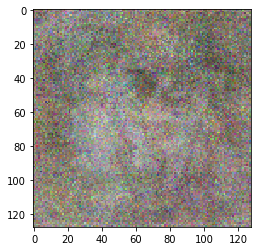

In [ ]:
v = np.random.normal(size=100)
fimg = generator.predict(np.array(([v,v])))[0]
fimg = (0.5+0.5*fimg)*255
fimg = np.array(fimg, 'i')
plt.imshow(fimg)